In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
        recall_score, classification_report, precision_recall_curve,\
        confusion_matrix, auc, roc_curve

In [3]:
from lightgbm import LGBMClassifier
import lightgbm
import  catboost as catb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [9]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
#from sklearn.impute import KNNImputer

In [11]:
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#import category_encoders as ce

In [12]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [13]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [14]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [15]:
def balance_df_by_target_advance(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [16]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [17]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [18]:
def choise_features(data, model):
    X = data.drop(columns=['target'])
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #lgb = LGBMClassifier(objective='binary',
     ##                   #n_estimators=50, 
    #                     #max_depth=3, 
    #                     metric = "f1",
    #                     #categorical_feature=cat_feats
    #                    )

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return X_train, X_test, y_train, y_test, feature_importances

In [19]:
def train_evaluate_preds(model, X_train, X_test, y_train, y_test):
    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #model_RF = RandomForestClassifier(random_state=21)

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [15]:
def target_encoder(X_train, y_train, X_test, encoded):
    Form = pd.concat([X_train[encoded], y_train], axis=1)
    Mask = pd.DataFrame(Form.groupby(by=encoded)['target'].mean()).\
           rename(columns={"target": f"{encoded}_mean"})
    X_train = pd.merge(X_train, Mask, how='left', on=encoded)
    X_test = pd.merge(X_test, Mask, how='left', on=encoded)
    
    return X_train, X_test

In [16]:
def log_columns(df, big_nunique_features):
    for col in big_nunique_features:
        const = np.min(df[col])
        if const > 0:
            const = 0
        else:
            const -= 0.1
        df[col] = np.log(df[col]-const+0.001)

In [20]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [21]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=21)

def run_cv(estimator, cv, X, y, scoring='f1_macro',  model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [19]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [20]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1039.31 MB
Memory usage after optimization is: 502.05 MB
Decreased by 51.7%
Memory usage of dataframe is 692.88 MB
Memory usage after optimization is: 342.31 MB
Decreased by 50.6%


In [21]:
train_df6 = train_df[train_df['vas_id']==6]
test_df6 = test_df[test_df['vas_id']==6]

In [22]:
train_df6.target.value_counts(normalize=True)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

In [23]:
test_df6.target.value_counts(normalize=True)

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

In [24]:
train_df6.head(10)

,id,vas_id,buy_time_x,0,1,2,3,4,5,6,...,vas_id_08,vas_id_09,month,day,weekofyear,time_max,novelty,vas_id_day,is_action,target
17,2781859,6.0,1545598800,-96.799973,57.920887,-28.240786,126.793205,-33.658245,105.688210,-16.086180,...,0,0,12,358,52,1546203600,604800,0,0,1.0
22,3409342,6.0,1544994000,64.220032,-227.309113,50.279213,-279.916809,44.861755,-301.021790,-16.086180,...,0,0,12,351,51,1546203600,1209600,0,0,1.0
31,3285344,6.0,1546203600,72.690033,316.390900,99.429214,361.233215,94.011757,340.128204,-16.086180,...,0,0,12,365,1,1546203600,0,0,0,0.0
42,1566189,6.0,1544389200,-4.589971,16.640888,-18.530787,-10.546799,-23.948246,-31.651789,-16.086180,...,0,0,12,344,50,1546203600,1814400,0,0,0.0
80,485042,6.0,1544389200,632.010010,490.110901,628.669189,460.823212,623.251770,439.718201,-16.086180,...,0,0,12,344,50,1546203600,1814400,0,0,1.0
86,1887409,6.0,1544994000,188.470032,716.780884,174.529221,672.653198,169.111755,651.548218,212.723816,...,0,0,12,351,51,1546203600,1209600,0,0,0.0
95,4081589,6.0,1544994000,117.950027,166.920883,104.009216,114.313202,98.591751,93.208214,-16.086180,...,0,0,12,351,51,1546203600,1209600,0,0,1.0
105,1785244,6.0,1544994000,22.980030,-17.599112,23.439215,-16.826797,18.021753,-37.931789,12.413820,...,0,0,12,351,51,1546203600,1209600,0,0,1.0
132,3616298,6.0,1545598800,-96.799973,-408.179108,-110.740784,-460.786804,-116.158249,-481.891785,-16.086180,...,0,0,12,358,52,1546203600,604800,0,0,0.0
154,3248877,6.0,1544994000,-96.799973,-384.459106,-110.740784,-437.066803,-116.158249,-458.171783,-16.086180,...,0,0,12,351,51,1546203600,1209600,0,0,1.0


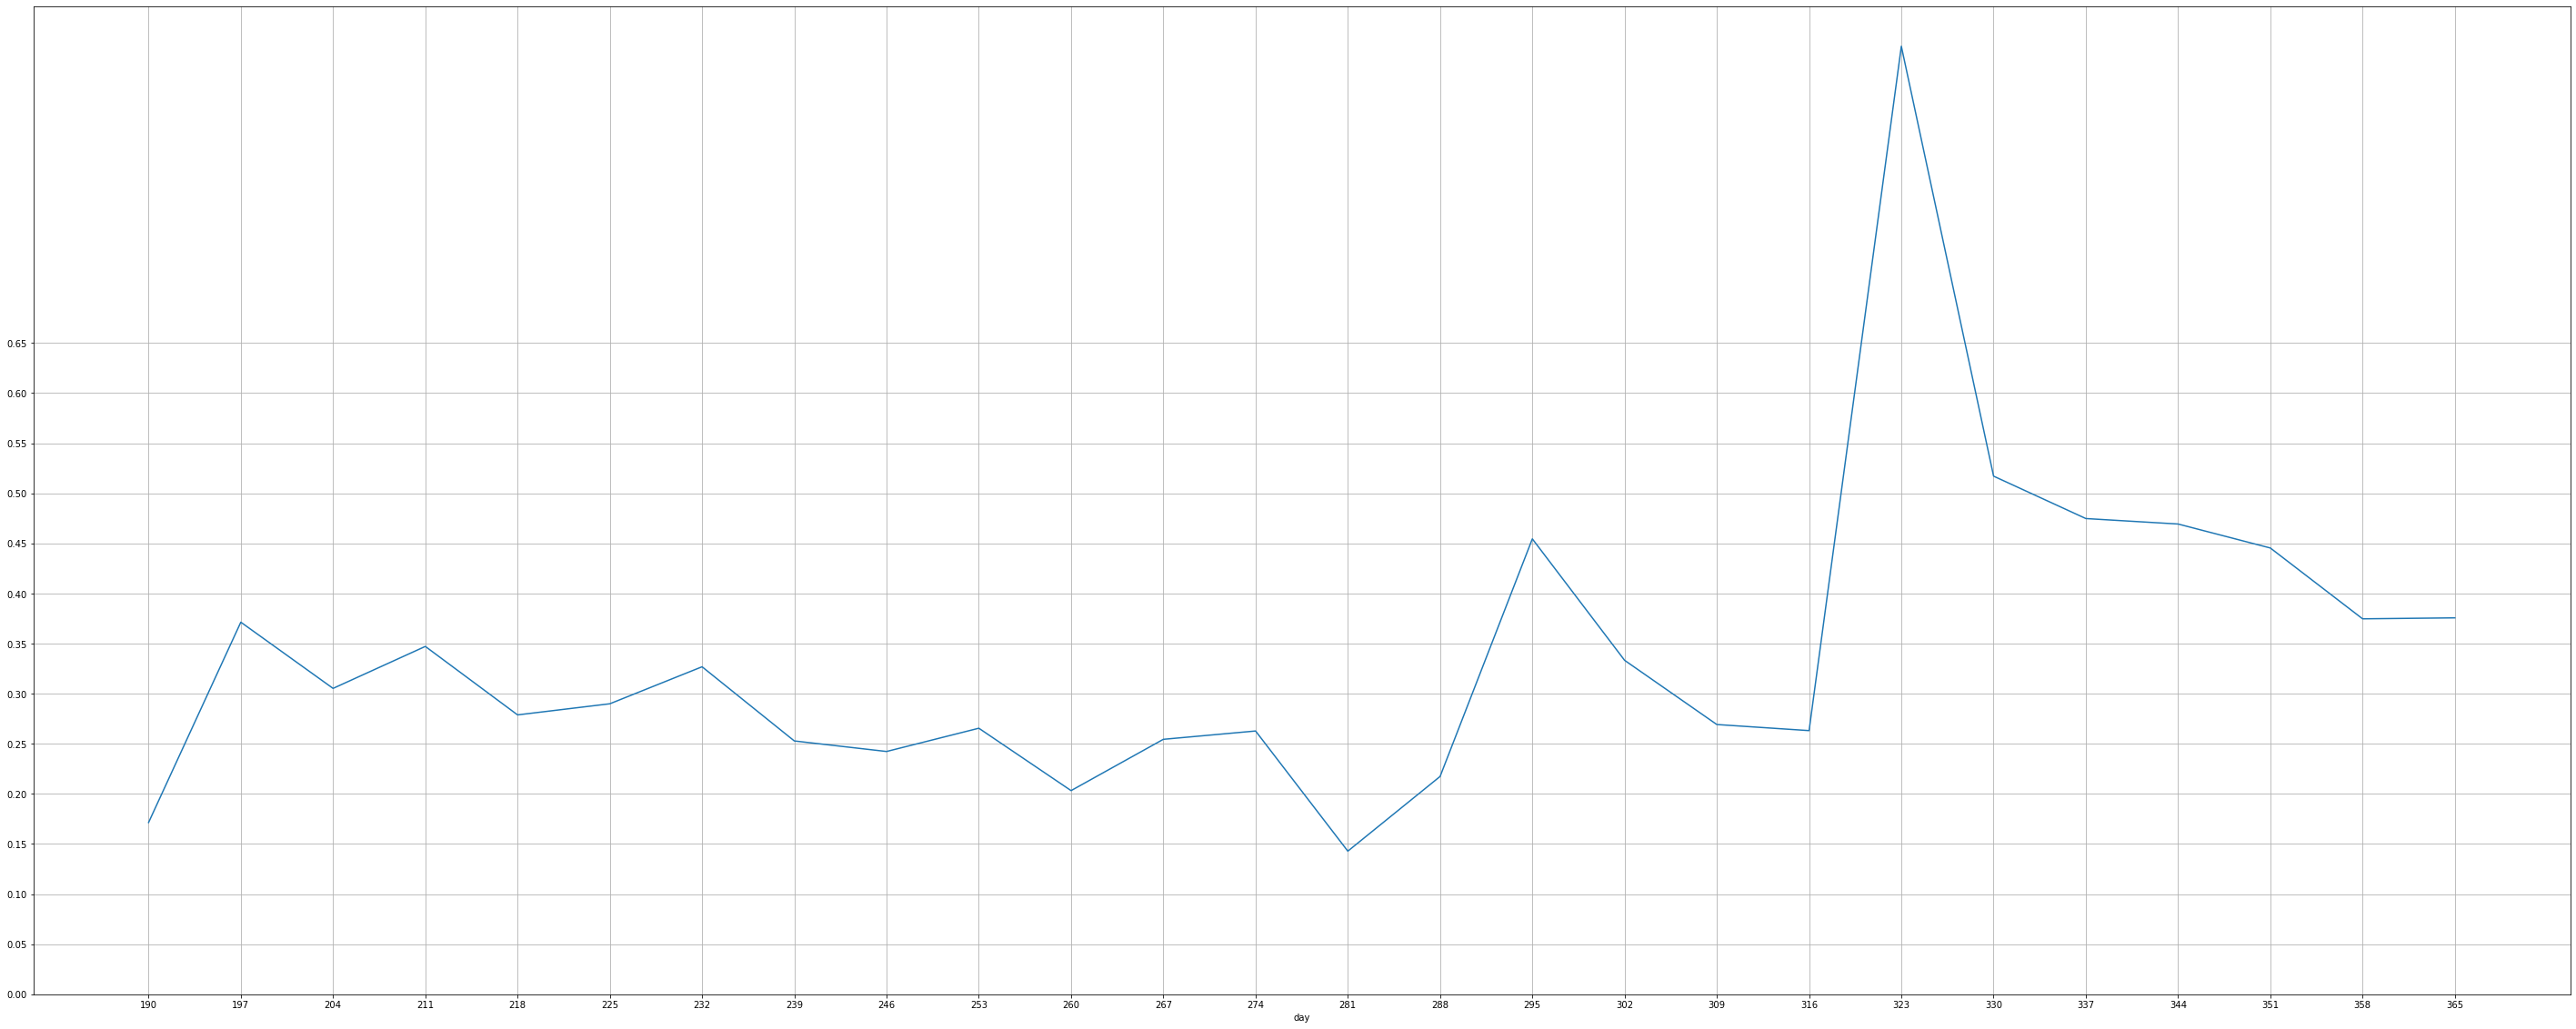

In [25]:
plt.figure(figsize=(50, 20))
train_df6.groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(train_df6['day'].unique())
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid()
plt.show()

Выброс с 317 по 344 день.

# Разбиение на  train  и  test

In [26]:
TARGET_NAME = 'target'

In [27]:
X_train = train_df6.drop(columns=[TARGET_NAME])
y_train = train_df6[TARGET_NAME]
X_test = test_df6.drop(columns=[TARGET_NAME])
y_test = test_df6[TARGET_NAME]

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

In [28]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0.0    19865
1.0    14811
Name: target, dtype: int64

In [29]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

# Поиск категориальных признаков среди вещественных

In [30]:
df_numerical = X_train.select_dtypes(include = [np.number])
df_categorical = X_train.select_dtypes(exclude = [np.number])

In [31]:
# Ищу признаки категориальные среди вещественных
select_spy = pd.DataFrame(df_numerical.nunique())

In [32]:
list_spy = select_spy.loc[select_spy[0] < 11].index.to_list()

In [33]:
list_spy.remove('vas_id')

In [34]:
#df_categorical = df_all[list_spy]

In [35]:
#df_numerical.drop(labels=list_spy, axis=1, inplace = True)
#вырезаем эти колонки из количественных данных

In [36]:
#df_numerical.drop(labels=['target'], axis=1, inplace = True)

In [37]:
# где у нас нули
#for i in df_numerical.columns:
#    print(i, df4[i][df4[i]==0].count())

In [38]:
# Проверка
Categorical_features = X_train_balanced.select_dtypes(exclude=[np.number])

In [39]:
cat_feats = Categorical_features.columns.to_list()

In [40]:
cat_feats

[]

In [41]:
#df4[list_spy] = df4[list_spy].astype('object')

In [42]:
#categorical_features = df4.select_dtypes(include=['object']).columns.to_list()

In [43]:
list_spy = ['15', '16', '17', '23', '24', '26', '27', '29', '30', '31', '32', '33', '35', '57',
     '65', '75', '81', '85', '95', '131', '132', '139', '154', '155', '179', '192', '194', '195',
     '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '212', '216',
     '218', '220', '221', '252', 'month']

# Выбор модели

In [58]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

1.3412328674633718

In [63]:
disbalance2 = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]
disbalance2

1.3412328674633718

scale_pos_weight не помог

# XGBClassifier

In [44]:
# manually handling imbalance. Below is same as computing float(18501)/392318 
#on the trainig dataset.
# We are going to inversely assign the weights
weight_ratio = float(len(y_train_balanced[y_train_balanced == 0]))/float(len(y_train_balanced[y_train_balanced == 1]))
w_array = np.array([1]*y_train_balanced.shape[0])
w_array[y_train_balanced==1] = weight_ratio
w_array[y_train_balanced==0] = 1- weight_ratio

sample_weight=w_array не повлиял на результат

In [87]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [88]:
feature_importances = train_evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

         0.0       0.76      0.96      0.85     19865
         1.0       0.92      0.59      0.72     14811

    accuracy                           0.80     34676
   macro avg       0.84      0.77      0.78     34676
weighted avg       0.83      0.80      0.79     34676

TEST

              precision    recall  f1-score   support

         0.0       0.61      0.82      0.70     13309
         1.0       0.55      0.29      0.38      9893

    accuracy                           0.59     23202
   macro avg       0.58      0.56      0.54     23202
weighted avg       0.58      0.59      0.56     23202

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     10955  2354
1.0      7043  2850


macro avg       0.88      0.65      0.71     87015

In [89]:
run_cv(model_xgb, kfold_cv, X_train, y_train, model_name="model_xgb");

model_xgb: f1_macro = 0.56 (+/- 0.00)


model_xgb: f1_macro = 0.56 (+/- 0.00)


In [47]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [48]:
feature_importances = train_evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

         0.0       0.76      0.96      0.85     19865
         1.0       0.92      0.59      0.72     14811

    accuracy                           0.80     34676
   macro avg       0.84      0.77      0.78     34676
weighted avg       0.83      0.80      0.79     34676

TEST

              precision    recall  f1-score   support

         0.0       0.61      0.82      0.70     13309
         1.0       0.55      0.29      0.38      9893

    accuracy                           0.59     23202
   macro avg       0.58      0.56      0.54     23202
weighted avg       0.58      0.59      0.56     23202

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     10955  2354
1.0      7043  2850


macro avg       0.77      0.87      0.81     28204

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

In [49]:
#run_cv(model_xgb, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_xgb");

model_xgb: f1_macro = 0.98 (+/- 0.00)



In [50]:
#show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

# LGBMClassifier

In [51]:
model_lgbm = LGBMClassifier(random_state=21)

Регуляризация не повлияла на результат

In [52]:
feature_importances = train_evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.67      0.97      0.79     19865
         1.0       0.91      0.34      0.50     14811

    accuracy                           0.71     34676
   macro avg       0.79      0.66      0.65     34676
weighted avg       0.77      0.71      0.67     34676

TEST

              precision    recall  f1-score   support

         0.0       0.61      0.92      0.73     13309
         1.0       0.65      0.19      0.30      9893

    accuracy                           0.61     23202
   macro avg       0.63      0.56      0.51     23202
weighted avg       0.62      0.61      0.55     23202

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     12269  1040
1.0      7994  1899


 macro avg       0.87      0.65      0.71     75129

In [53]:
#run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1 = 0.61 (+/- 0.01)

In [54]:
model_lgbm = LGBMClassifier(random_state=21)

In [55]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.67      0.97      0.79     19865
         1.0       0.91      0.34      0.50     14811

    accuracy                           0.71     34676
   macro avg       0.79      0.66      0.65     34676
weighted avg       0.77      0.71      0.67     34676

TEST

              precision    recall  f1-score   support

         0.0       0.61      0.92      0.73     13309
         1.0       0.65      0.19      0.30      9893

    accuracy                           0.61     23202
   macro avg       0.63      0.56      0.51     23202
weighted avg       0.62      0.61      0.55     23202

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     12269  1040
1.0      7994  1899


macro avg       0.78      0.87      0.82     28204

In [56]:
#run_cv(model_lgbm, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_lgbm");

model_lgbm: f1_macro = 0.99 (+/- 0.00)

In [57]:
#show_learning_curve_plot(model_lgbm, X_train_balanced, y_train_balanced)

# CatBoostClassifier

In [59]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features': [],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [60]:
model_catb = catb.CatBoostClassifier(**frozen_params)

In [61]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82     19865
         1.0       0.76      0.74      0.75     14811

    accuracy                           0.79     34676
   macro avg       0.79      0.78      0.79     34676
weighted avg       0.79      0.79      0.79     34676

TEST

              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65     13309
         1.0       0.52      0.47      0.49      9893

    accuracy                           0.59     23202
   macro avg       0.57      0.57      0.57     23202
weighted avg       0.58      0.59      0.58     23202

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     8945  4364
1.0     5238  4655


macro avg       0.76      0.83      0.79     75129

In [85]:
run_cv(model_catb, kfold_cv, X_train, y_train, model_name="model_catb");

model_catb: f1_macro = 0.58 (+/- 0.01)


model_catb: f1_macro = 0.58 (+/- 0.01)


In [64]:
frozen_params2 = {
     'class_weights':[1, disbalance2], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month', 'clasters_3', 'clasters_7'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [65]:
model_catb2 = catb.CatBoostClassifier(**frozen_params2)

In [66]:
feature_importances = train_evaluate_preds(model_catb2, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82     19865
         1.0       0.77      0.74      0.75     14811

    accuracy                           0.79     34676
   macro avg       0.79      0.79      0.79     34676
weighted avg       0.79      0.79      0.79     34676

TEST

              precision    recall  f1-score   support

         0.0       0.63      0.68      0.65     13309
         1.0       0.51      0.46      0.49      9893

    accuracy                           0.58     23202
   macro avg       0.57      0.57      0.57     23202
weighted avg       0.58      0.58      0.58     23202

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     9003  4306
1.0     5325  4568


macro avg       0.78      0.87      0.81     28204

In [86]:
run_cv(model_catb2, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_catb");

model_catb: f1_macro = 0.58 (+/- 0.00)


model_catb: f1_macro = 0.58 (+/- 0.00)




In [68]:
#show_learning_curve_plot(model_catb, X_train_balanced, y_train_balanced)

# RandomForestClassifier

In [81]:
model_RF = RandomForestClassifier(random_state=21, class_weight={0:.57, 1:.43})

RandomForestClassifier без ccp_alpha дает полное переобучение на трейне, ввел коэффициент.

In [82]:
feature_importances = train_evaluate_preds(model_RF, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19865
         1.0       1.00      1.00      1.00     14811

    accuracy                           1.00     34676
   macro avg       1.00      1.00      1.00     34676
weighted avg       1.00      1.00      1.00     34676

TEST

              precision    recall  f1-score   support

         0.0       0.61      0.86      0.71     13309
         1.0       0.57      0.25      0.34      9893

    accuracy                           0.60     23202
   macro avg       0.59      0.55      0.53     23202
weighted avg       0.59      0.60      0.55     23202

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     11464  1845
1.0      7454  2439


macro avg       0.79      0.83      0.81     75129

In [71]:
#run_cv(model_RF, kfold_cv, X_train_balanced, y_train_balanced, model_name="model_RF");

In [83]:
model_RF2 = RandomForestClassifier(random_state=21, class_weight={0:.57, 1:.43})

In [84]:
feature_importances2 = train_evaluate_preds(model_RF, X_train, X_test, y_train, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19865
         1.0       1.00      1.00      1.00     14811

    accuracy                           1.00     34676
   macro avg       1.00      1.00      1.00     34676
weighted avg       1.00      1.00      1.00     34676

TEST

              precision    recall  f1-score   support

         0.0       0.61      0.86      0.71     13309
         1.0       0.57      0.24      0.34      9893

    accuracy                           0.60     23202
   macro avg       0.59      0.55      0.53     23202
weighted avg       0.59      0.60      0.55     23202

CONFUSION MATRIX

col_0     0.0   1.0
target             
0.0     11506  1803
1.0      7475  2418


macro avg       0.49      0.50      0.50     87015

In [74]:
#run_cv(model_RF2, kfold_cv, X_train, y_train, model_name="model_RF");

model_RF2: f1 = 0.52 (+/- 0.01)


In [75]:
#show_learning_curve_plot(model_RF, X_train_balanced, y_train_balanced)

По результатам отборочных туров, главным тренером команды назначен CatBoostClassifier на несбалансированных данных.

# Выбор метода балансировки датасета

In [ ]:
#df_balanced_tomek = balance_df_by_target_advance(df_for_balancing, 'target', method='tomek')

In [ ]:
#X_train_tomek = df_balanced_tomek.drop(columns=TARGET_NAME)
#y_train_tomek = df_balanced_tomek[TARGET_NAME]

In [ ]:
#disbalance_t = y_train_tomek.value_counts()[0] / y_train_tomek.value_counts()[1]
#disbalance_t

In [ ]:
#frozen_params_t = {
 #    'class_weights':[1, disbalance_t], 
  #   'silent':True,
   #  'random_state':21,
    # 'eval_metric':'F1',
    # 'early_stopping_rounds':60
#}

In [ ]:
#model_catb_t = catb.CatBoostClassifier(**frozen_params_t, reg_lambda = 0.1)

In [ ]:
#feature_importances = train_evaluate_preds(model_catb_t, X_train_tomek, X_test, y_train_tomek, y_test)

In [ ]:
#df_smote = balance_df_by_target_advance(df_for_balancing, 'target', method='smote')

In [ ]:
#X_train_smote= df_smote.drop(columns=TARGET_NAME)
#y_train_smote = df_smote[TARGET_NAME]

In [ ]:
#disbalance_s = y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]
#disbalance_s

In [ ]:
#frozen_params_s = {
#     'class_weights':[1, disbalance_s], 
#     'silent':True,
#     'random_state':21,
#     'eval_metric':'F1',
#     'early_stopping_rounds':60
#}

In [ ]:
#model_catb_s = catb.CatBoostClassifier(**frozen_params_s, reg_lambda = 0.1)

In [ ]:
#feature_importances = train_evaluate_preds(model_catb_s, X_train_smote, X_test, y_train_smote, y_test)

In [ ]:
#run_cv(model_catb_s, kfold_cv, X_train_smote, y_train_smote, model_name="model_catb");

In [ ]:
#fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [ ]:
#feature_importances = train_evaluate_preds(model_catb_s, X_train_smote[fea_imp], X_test[fea_imp], y_train_smote, y_test)

In [ ]:
#X_train = X_train_smote[fea_imp]
#X_test = X_test[fea_imp]
#y_train = y_train_smote

# Удаление признаков

In [90]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82     19865
         1.0       0.76      0.74      0.75     14811

    accuracy                           0.79     34676
   macro avg       0.79      0.78      0.79     34676
weighted avg       0.79      0.79      0.79     34676

TEST

              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65     13309
         1.0       0.52      0.47      0.49      9893

    accuracy                           0.59     23202
   macro avg       0.57      0.57      0.57     23202
weighted avg       0.58      0.59      0.58     23202

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     8945  4364
1.0     5238  4655


In [91]:
fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [92]:
len(fea_imp)

235

In [93]:
X_train.shape

(34676, 272)

In [94]:
feature_importances = train_evaluate_preds(model_catb, X_train[fea_imp], X_test[fea_imp], y_train, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82     19865
         1.0       0.76      0.74      0.75     14811

    accuracy                           0.79     34676
   macro avg       0.78      0.78      0.78     34676
weighted avg       0.79      0.79      0.79     34676

TEST

              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65     13309
         1.0       0.52      0.47      0.49      9893

    accuracy                           0.59     23202
   macro avg       0.57      0.57      0.57     23202
weighted avg       0.58      0.59      0.58     23202

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     8973  4336
1.0     5261  4632
[20:21:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the o

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:21:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[20:21:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [95]:
X_train = X_train[fea_imp]
X_test = X_test[fea_imp]

Чемпионат был длинный и часть игроков померла а часть еле дышит. Вызываю санитаров.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [96]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [97]:
lr = LinearRegression()
#select 10 the most informative features
rfe = RFE(lr)
selector = rfe.fit(X_train, y_train)

In [98]:
selector.ranking_

array([112,   1,   1,  84,   1,  92,   1,  85,   1,  99,   1,  89,   1,
         1,   1,  52,   1,   1,   1,   1,   1,  74,   1,  66,   1,   1,
         1,   1,   1,   1,  37,   1,  11,  98,   1,   1,   1,   8,  23,
         1,   1,   1,  95,  86,  91, 102,   1,   1,  90,  65,   1,  67,
        12,  45,  10,   1,   1,   1,   1,   1,   1,   1,  19,   4,   1,
         1,   1,   1,   1,  35,  60,  56,  73,  30,  62,   1,   1,   1,
         1,  41,  43,  63,  39,  47,   1,  24,  14,  96,  97,   1,  36,
        34,  20,   1,  54,  13,  53,  57,   1,   1,   1,   1,   1,   1,
         1, 106,   6,  77,   7,   1,   1,   1,   1,   1,   1,   1,  46,
        32,   1,   1,  94,   1,   1,   1,   1,  70,   1,   1,   1, 107,
        33,  38,  21,   1,   1,   1,   1,   1,   1,   1,   1,  28,   1,
         1,   1,   1,   1,  22,  17,  76,  18,  55,  16,  31,  68,  69,
        42,   1,   1,   1,   1,  25,  78,  49,  48,  15,   1,  26,   1,
         1,   1,  88,   1,   3,   1,   1,   1,   1,   1,   1,   

In [99]:
value = np.array(X_train.columns.to_list())
mask = selector.support_
last_col = list(value[mask])
last_col.extend(['id'])
X_train_short = X_train[last_col]

In [100]:
X_test_short = X_test[last_col]

In [101]:
feature_importances = train_evaluate_preds(model_catb, X_train_short, X_test_short, y_train, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79     19865
         1.0       0.72      0.70      0.71     14811

    accuracy                           0.76     34676
   macro avg       0.75      0.75      0.75     34676
weighted avg       0.75      0.76      0.75     34676

TEST

              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65     13309
         1.0       0.52      0.48      0.50      9893

    accuracy                           0.59     23202
   macro avg       0.57      0.57      0.57     23202
weighted avg       0.58      0.59      0.58     23202

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     8917  4392
1.0     5183  4710


In [102]:
X_train = X_train_short
X_test = X_test_short

In [103]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79     19865
         1.0       0.72      0.70      0.71     14811

    accuracy                           0.76     34676
   macro avg       0.75      0.75      0.75     34676
weighted avg       0.75      0.76      0.75     34676

TEST

              precision    recall  f1-score   support

         0.0       0.63      0.67      0.65     13309
         1.0       0.52      0.48      0.50      9893

    accuracy                           0.59     23202
   macro avg       0.57      0.57      0.57     23202
weighted avg       0.58      0.59      0.58     23202

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     8917  4392
1.0     5183  4710


/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


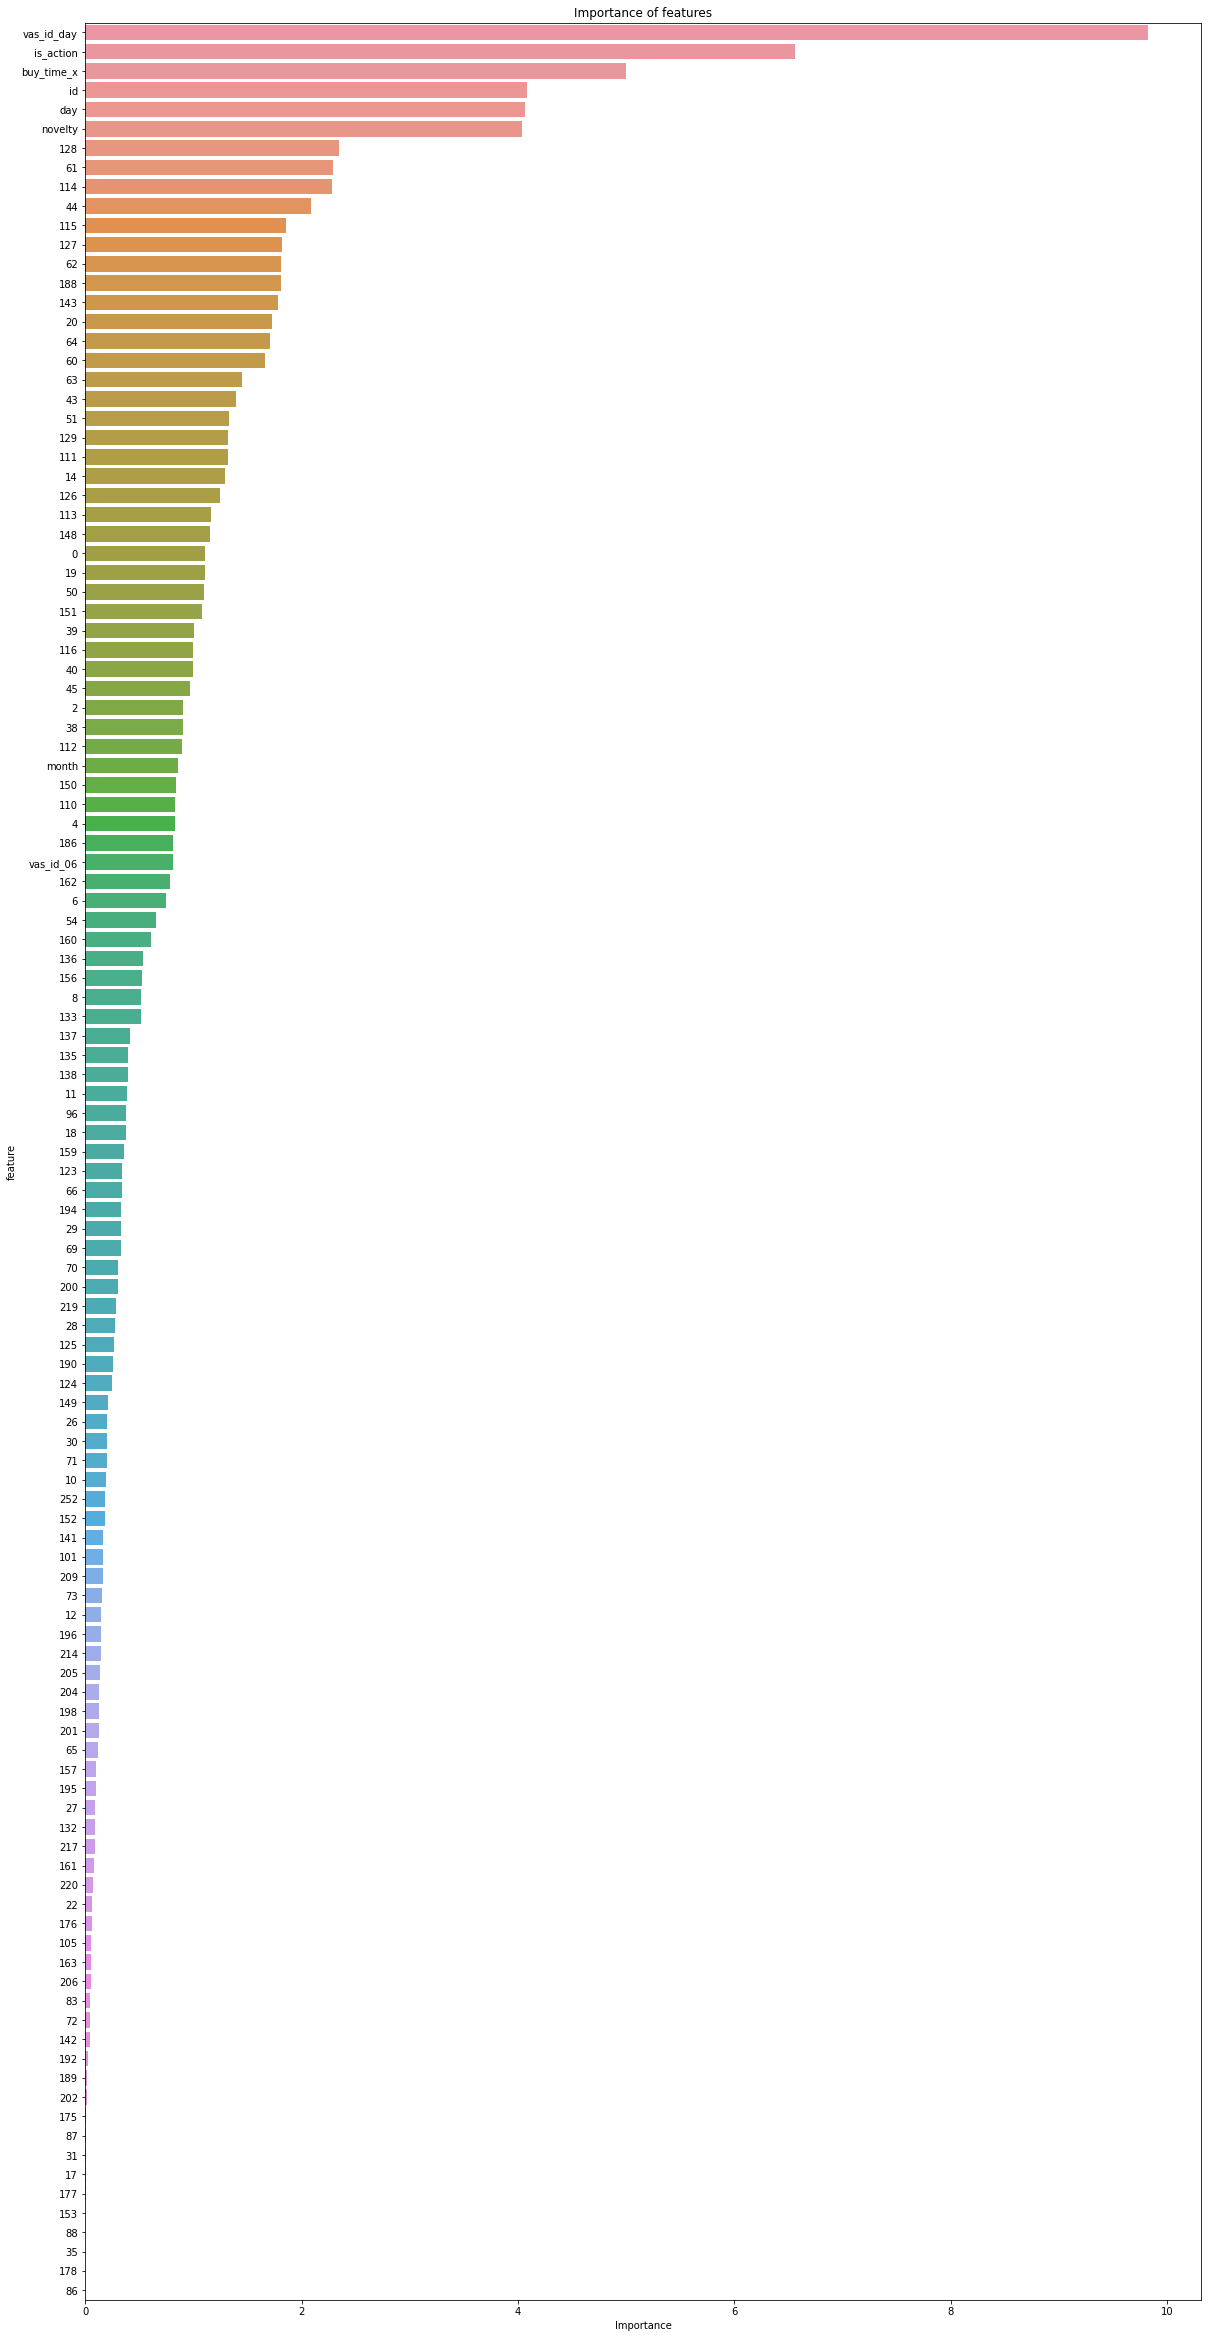

['vas_id_day', 'is_action', 'buy_time_x', 'id', 'day']

In [104]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'], get_top = 5)

# SHAP

In [105]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [106]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_catb)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

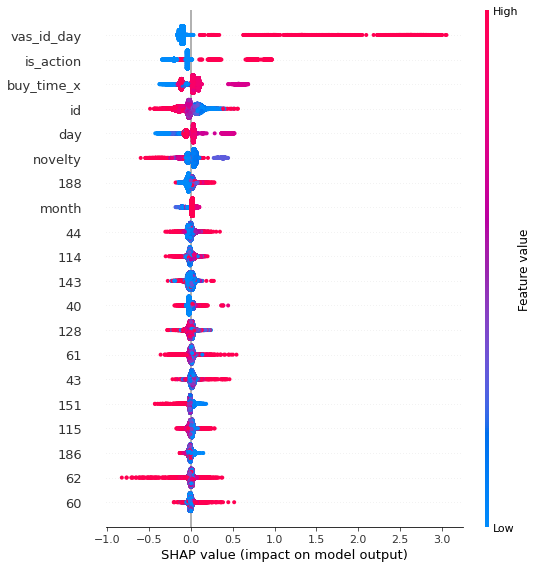

In [107]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать:

    значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
    чем толще линия на графике, тем больше таких точек наблюдения
    чем краснее точка на графике, тем выше значения признака в ней


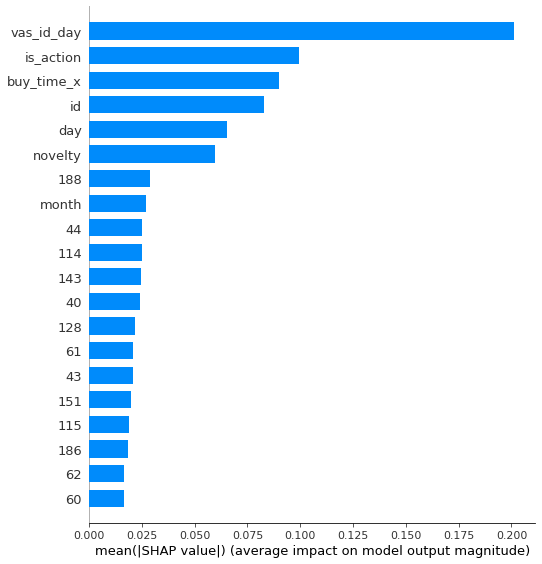

In [108]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [141]:
# Закладка
train_df6 = pd.concat([X_train, y_train], axis=1)
test_df6 = pd.concat([X_test, y_test], axis=1)
train_df6.to_csv('train_df6.csv', index=False)
test_df6.to_csv('test_df6.csv', index=False)

In [142]:
train_df6 = pd.read_csv('train_df6.csv')
test_df6 = pd.read_csv('test_df6.csv')
X_test = test_df6.drop(columns=['target'])
y_test = test_df6['target']
X_train = train_df6.drop(columns=['target'])
y_train = train_df6['target']

# Подбор гиперпараметров

In [111]:
from matplotlib import pyplot

Исследование количества деревьев


In [112]:
# get a list of models to evaluate
def get_models():
    models = dict()
    trees = [50, 100, 200, 500, 1000]
    for n in trees:
        models[str(n)] = catb.CatBoostClassifier(random_state = 21, iterations=n, silent = True)
    return models

In [113]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [114]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>50 0.549 (0.005)
>100 0.549 (0.007)
>200 0.549 (0.003)
>500 0.543 (0.004)
>1000 0.542 (0.005)


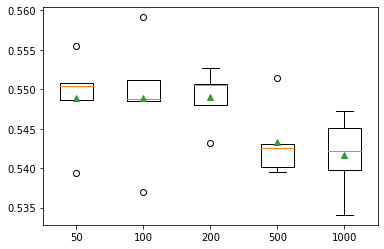

In [115]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование глубины дерева


In [116]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1,7):
        models[str(i)] = catb.CatBoostClassifier(max_depth=i, num_leaves=2**i,
                                            random_state=21, silent = True)
    return models

In [117]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [118]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>1 0.529 (0.007)
>2 0.528 (0.006)
>3 0.529 (0.005)
>4 0.531 (0.005)
>5 0.536 (0.004)
>6 0.542 (0.005)


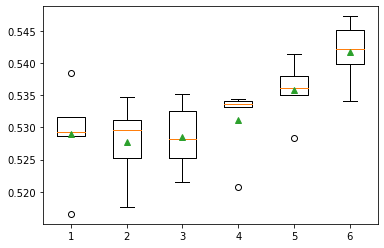

In [119]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование скорости обучения

In [120]:
# get a list of models to evaluate
def get_models():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = catb.CatBoostClassifier(learning_rate=r,
                                            random_state=21, silent = True)
    return models

In [121]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [122]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.0001 0.497 (0.005)
>0.0010 0.510 (0.011)
>0.0100 0.520 (0.003)
>0.1000 0.556 (0.004)
>1.0000 0.550 (0.009)


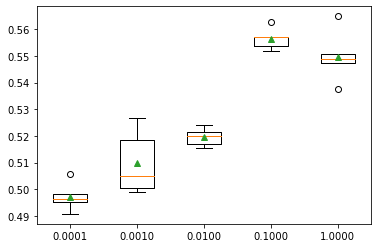

In [123]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование регуляризации

In [124]:
# get a list of models to evaluate
def get_models():
    models = dict()
    types = [0.1,1,2,4,8]
    for t in types:
        models[t] = catb.CatBoostClassifier(l2_leaf_reg=t,
                                            random_state=21, silent=True)
    return models

In [125]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [126]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.1 0.536 (0.006)
>1 0.537 (0.004)
>2 0.534 (0.005)
>4 0.532 (0.004)
>8 0.533 (0.006)


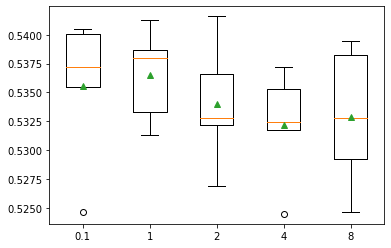

In [127]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [128]:
params = {'n_estimators':[50, 200],
          'max_depth':[5, 6, 7, 9]}

In [129]:
model_catb = catb.CatBoostClassifier(**frozen_params)

In [132]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [133]:
%%time

grid_search = model_catb.randomized_search(params, X_train, y_train, n_iter = 50, cv = cv, stratified = True, plot = True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.593483873
bestIteration = 17

0:	loss: 0.5934839	best: 0.5934839 (0)	total: 1.25s	remaining: 8.76s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.593483873
bestIteration = 17

1:	loss: 0.5934839	best: 0.5934839 (0)	total: 3.02s	remaining: 9.07s

bestTest = 0.5841737471
bestIteration = 22

2:	loss: 0.5841737	best: 0.5934839 (0)	total: 4.39s	remaining: 7.31s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.5841737471
bestIteration = 22

3:	loss: 0.5841737	best: 0.5934839 (0)	total: 6.55s	remaining: 6.55s

bestTest = 0.6190237456
bestIteration = 8

4:	loss: 0.6190237	best: 0.6190237 (4)	total: 8.37s	remaining: 5.02s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.6190237456
bestIteration = 8

5:	loss: 0.6190237	best: 0.6190237 (4)	total: 10.9s	remaining: 3.63s

bestTest = 0.6246712276
bestIteration = 10

6:	loss: 0.6246712	best: 0.6246712 (6)	total: 16s	remaining: 2.29s
Stopped by overfitting detector  (60 iteration

In [138]:
best_model = catb.CatBoostClassifier(**frozen_params, n_estimators = 50, max_depth=7)

In [139]:
best_model.fit(X_train, y_train)

In [140]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72     19865
         1.0       0.62      0.63      0.62     14811

    accuracy                           0.68     34676
   macro avg       0.67      0.67      0.67     34676
weighted avg       0.68      0.68      0.68     34676

TEST

              precision    recall  f1-score   support

         0.0       0.63      0.64      0.64     13309
         1.0       0.51      0.50      0.50      9893

    accuracy                           0.58     23202
   macro avg       0.57      0.57      0.57     23202
weighted avg       0.58      0.58      0.58     23202

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     8576  4733
1.0     4955  4938


# Снижение степени переобучения

In [160]:
params = {'l2_leaf_reg': [0.1, 1],
         'learning_rate': [0.1, 1]
         }

In [161]:
best_model = catb.CatBoostClassifier(**frozen_params, n_estimators = 50, max_depth = 7)

In [162]:
grid_search = best_model.randomized_search(params, X_train, y_train, n_iter = 50, cv = cv, stratified = True, plot = True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6147579559
bestIteration = 6

0:	loss: 0.6147580	best: 0.6147580 (0)	total: 1.96s	remaining: 5.89s

bestTest = 0.553203313
bestIteration = 5

1:	loss: 0.5532033	best: 0.6147580 (0)	total: 3.93s	remaining: 3.93s

bestTest = 0.5840081039
bestIteration = 2

2:	loss: 0.5840081	best: 0.6147580 (0)	total: 5.72s	remaining: 1.91s

bestTest = 0.546578331
bestIteration = 47

3:	loss: 0.5465783	best: 0.6147580 (0)	total: 7.53s	remaining: 0us
Estimating final quality...


Поисковые сетки ничего не знают о требованиях Мегафона к average: macro, и ищут взвешенные метрики. Придется обломиться с поиском.

In [165]:
best_model = catb.CatBoostClassifier(**frozen_params,  learning_rate = 0.1, n_estimators = 50, max_depth=7)

In [166]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66     19865
         1.0       0.55      0.55      0.55     14811

    accuracy                           0.61     34676
   macro avg       0.61      0.61      0.61     34676
weighted avg       0.61      0.61      0.61     34676

TEST

              precision    recall  f1-score   support

         0.0       0.64      0.65      0.65     13309
         1.0       0.52      0.52      0.52      9893

    accuracy                           0.59     23202
   macro avg       0.58      0.58      0.58     23202
weighted avg       0.59      0.59      0.59     23202

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     8642  4667
1.0     4779  5114


# Штрафую нули

In [194]:
frozen_params = {
     'class_weights':[1, 1.4], 
     'silent':True,
     'random_state':21,
     #'cat_features': [],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [195]:
best_model = catb.CatBoostClassifier(**frozen_params,  learning_rate = 0.1, n_estimators = 50, max_depth=7)

In [196]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.572875
1.0    0.427125
Name: target, dtype: float64

0.0    0.573614
1.0    0.426386
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       0.68      0.58      0.63     19865
         1.0       0.53      0.62      0.57     14811

    accuracy                           0.60     34676
   macro avg       0.60      0.60      0.60     34676
weighted avg       0.61      0.60      0.60     34676

TEST

              precision    recall  f1-score   support

         0.0       0.65      0.57      0.61     13309
         1.0       0.51      0.59      0.55      9893

    accuracy                           0.58     23202
   macro avg       0.58      0.58      0.58     23202
weighted avg       0.59      0.58      0.58     23202

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     7635  5674
1.0     4055  5838


In [197]:
run_cv(best_model, kfold_cv, X_train, y_train, model_name="best_model");

best_model: f1_macro = 0.58 (+/- 0.01)


best_model: f1_macro = 0.58 (+/- 0.01)


# Подбор порога

In [198]:
#наши прогнозы для тестовой выборки
preds = best_model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.4966573 , 0.5255856 , 0.48679741, 0.50649673, 0.40165876,
       0.46943381, 0.51236624, 0.54623248, 0.54647257, 0.66528384])

In [199]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.378532, F-Score=0.603, Precision=0.443, Recall=0.945


In [200]:
def predict_proba_to_int(y_predicted_probs, threshold):
         return (y_predicted_probs > threshold)*1

In [201]:
# Нашли метки предсказания для лучшего порога
best_predict = predict_proba_to_int(preds, thresholds[ix])

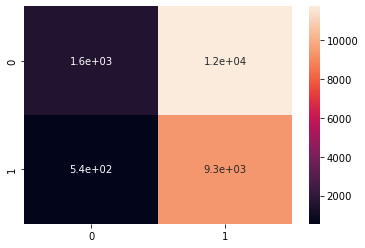

In [202]:
sns.heatmap(confusion_matrix(y_test, best_predict), annot=True)
plt.show()

Модернизирую функцию evaluate_preds для получения скоров с учетом лучшего вероятностного порога.

In [203]:
def evaluate_preds_with_threshold(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_poba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test,\
                                                           y_test_poba)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    best_predict = predict_proba_to_int(y_test_poba, thresholds[ix])
    

    get_classification_report(y_train, y_train_pred, y_test, best_predict)
    print('Best Threshold=%f' % (thresholds[ix]))
    
    return best_predict

In [204]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.68      0.58      0.63     19865
         1.0       0.53      0.62      0.57     14811

    accuracy                           0.60     34676
   macro avg       0.60      0.60      0.60     34676
weighted avg       0.61      0.60      0.60     34676

TEST

              precision    recall  f1-score   support

         0.0       0.65      0.57      0.61     13309
         1.0       0.51      0.59      0.55      9893

    accuracy                           0.58     23202
   macro avg       0.58      0.58      0.58     23202
weighted avg       0.59      0.58      0.58     23202

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     7635  5674
1.0     4055  5838


In [205]:
best_predict = evaluate_preds_with_threshold(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.68      0.58      0.63     19865
         1.0       0.53      0.62      0.57     14811

    accuracy                           0.60     34676
   macro avg       0.60      0.60      0.60     34676
weighted avg       0.61      0.60      0.60     34676

TEST

              precision    recall  f1-score   support

         0.0       0.74      0.12      0.20     13309
         1.0       0.44      0.94      0.60      9893

    accuracy                           0.47     23202
   macro avg       0.59      0.53      0.40     23202
weighted avg       0.61      0.47      0.37     23202

CONFUSION MATRIX

col_0      0      1
target             
0.0     1556  11753
1.0      545   9348
Best Threshold=0.378532


Удалось повысить на 1% метрику и снизить на 1% переобучение.

Написал функцию для тонкой настройки трешхолда

In [ ]:
def predict_proba_compare(model, X_test, X_train, y_test, y_train, cut_off):
    # функция изменения линии отсечки при расчете таргета
    pred_proba_test = model.predict_proba(X_test)
    y_test_proba=np.where(pred_proba_test[:, 1] > cut_off, 1, 0)
    pred_proba_train = model.predict_proba(X_train)
    y_train_proba=np.where(pred_proba_train[:, 1] > cut_off, 1, 0)
    print('TRAIN\n\n' + classification_report(y_train, y_train_proba))
    print('TEST\n\n' + classification_report(y_test, y_test_proba))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test, y_test_proba))
    
    return y_train_proba, y_test_proba

In [ ]:
predict_proba_compare(best_model, X_test, X_train, y_test, y_train, 0.54)

С трешхолдом нет смысла возиться.

In [206]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [207]:
y_test_poba = best_model.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[7635 5674]
 [4055 5838]]


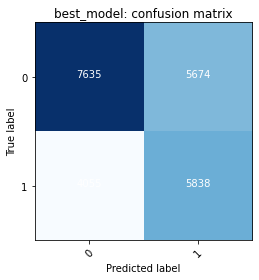

In [208]:
cm = confusion_matrix(y_test, y_test_poba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

# СОЗДАЮ ПАЙПЛАЙН

На несбалансированных данных! 

In [1]:
columns6 = ['buy_time_x', '0', '2', '4', '6', '8', '10', '11', '12', '14', '17', '18',
      '19', '20', '22', '26', '27', '28', '29', '30', '31', '35', '38', '39', '40',
      '43', '44', '45', '50', '51', '54', '60', '61', '62', '63', '64', '65', '66',
      '69', '70', '71', '72', '73', '83', '86', '87', '88', '96', '101', '105', '110',
      '111', '112', '113', '114', '115', '116', '123', '124', '125', '126', '127',
      '128', '129', '132', '133', '135', '136', '137', '138', '141', '142', '143',
      '148', '149', '150', '151', '152', '153', '156', '157', '159', '160', '161',
      '162', '163', '175', '176', '177', '178', '186', '188', '189', '190', '192',
      '194', '195', '196', '198', '200', '201', '202', '204', '205', '206', '209',
      '214', '217', '219', '220', '252', 'vas_id_06', 'month', 'day', 'novelty',
      'vas_id_day', 'is_action', 'id']

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [4]:
Selected_Columns = Pipeline([
                ('selector', ColumnSelector(columns6))
            ])

In [22]:
pipeline = Pipeline([
    ('Selected_Columns', Selected_Columns),
    ('classifier', catb.CatBoostClassifier(class_weights = [1, 1.4], random_state = 21, eval_metric = 'F1', learning_rate = 0.1, n_estimators = 50, max_depth=7))
])

# Сохранение модели

In [4]:
import pickle

In [24]:
with open('model_6.pkl', 'wb') as model:
    pickle.dump(pipeline, model)

In [25]:
with open('model_6.pkl', 'rb') as model:
    x = pickle.load(model)

In [218]:
x.fit(X_test, y_test)

0:	learn: 0.5184478	total: 30.1ms	remaining: 1.47s
1:	learn: 0.5185363	total: 58.3ms	remaining: 1.4s
2:	learn: 0.6290085	total: 87.1ms	remaining: 1.36s
3:	learn: 0.5638707	total: 116ms	remaining: 1.33s
4:	learn: 0.5557492	total: 144ms	remaining: 1.3s
5:	learn: 0.5459237	total: 172ms	remaining: 1.26s
6:	learn: 0.5676439	total: 200ms	remaining: 1.23s
7:	learn: 0.5550941	total: 226ms	remaining: 1.19s
8:	learn: 0.5734994	total: 262ms	remaining: 1.2s
9:	learn: 0.5696767	total: 292ms	remaining: 1.17s
10:	learn: 0.5912847	total: 320ms	remaining: 1.14s
11:	learn: 0.5881112	total: 348ms	remaining: 1.1s
12:	learn: 0.6036070	total: 377ms	remaining: 1.07s
13:	learn: 0.6038668	total: 406ms	remaining: 1.04s
14:	learn: 0.5934188	total: 436ms	remaining: 1.02s
15:	learn: 0.5967949	total: 466ms	remaining: 990ms
16:	learn: 0.5978329	total: 502ms	remaining: 975ms
17:	learn: 0.5968628	total: 531ms	remaining: 944ms
18:	learn: 0.5970328	total: 557ms	remaining: 909ms
19:	learn: 0.6012332	total: 585ms	remainin

Pipeline(steps=[('Selected_Columns',
                 Pipeline(steps=[('selector',
                                  ColumnSelector(key=['buy_time_x', '0', '2',
                                                      '4', '6', '8', '10', '11',
                                                      '12', '14', '17', '18',
                                                      '19', '20', '22', '26',
                                                      '27', '28', '29', '30',
                                                      '31', '35', '38', '39',
                                                      '40', '43', '44', '45',
                                                      '50', '51', ...]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fc502a53e50>)])

Confusion matrix, without normalization
[[8210 5099]
 [3886 6007]]


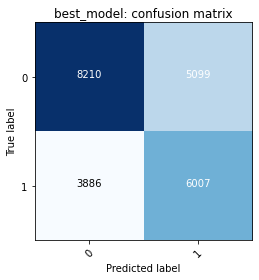

In [219]:
y_test_proba = x.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

Какая-то чехарда с конфужн-матрицами, но в результате правильно предсказанных больше. Ну ладно.

In [5]:
frozen_params = {
     'class_weights':[1, 1.4], 
     'silent':True,
     'random_state':21,
     #'cat_features': [],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [6]:
best_model = catb.CatBoostClassifier(**frozen_params,  learning_rate = 0.1, n_estimators = 50, max_depth=7)

In [7]:
with open('model6.pkl', 'wb') as model:
    pickle.dump(best_model, model)

In [ ]:
with open('model6.pkl', 'rb') as model:
    loaded_model = pickle.load(model)

In [ ]:
y_test_proba = loaded_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");